In [13]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, nltk, re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
import plotly.graph_objects as go
from collections import Counter
nltk.download('stopwords')
STOP = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/ayyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 📥 1. Load & First Look at the Dataset  
**Purpose:**  
Read the CSV file into a DataFrame and perform a quick sanity check—peek at the first few rows, confirm the shape, and spot any missing values.

In [14]:
df = pd.read_csv('resume_job_matching_dataset.csv')
display(df.head(), df.shape, df.isna().sum())

,job_description,resume,match_score
0,"Data Analyst needed with experience in SQL, Ex...","Experienced professional skilled in SQL, Power...",4
1,Data Scientist needed with experience in Stati...,"Experienced professional skilled in Python, De...",4
2,Software Engineer needed with experience in Sy...,"Experienced professional skilled in wait, Git,...",5
3,"ML Engineer needed with experience in Python, ...","Experienced professional skilled in return, De...",4
4,Software Engineer needed with experience in RE...,"Experienced professional skilled in REST APIs,...",5


(10000, 3)

job_description    0
resume             0
match_score        0
dtype: int64

## 📊 2. Distribution of Match Scores  
**Purpose:**  
Inspect how many samples fall into each discrete match-score bucket. This helps determine class balance and informs downstream modeling choices.



/tmp/ipykernel_124439/2794802805.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




match_score
1     440
2    1890
3    2269
4    3029
5    2372
Name: count, dtype: int64


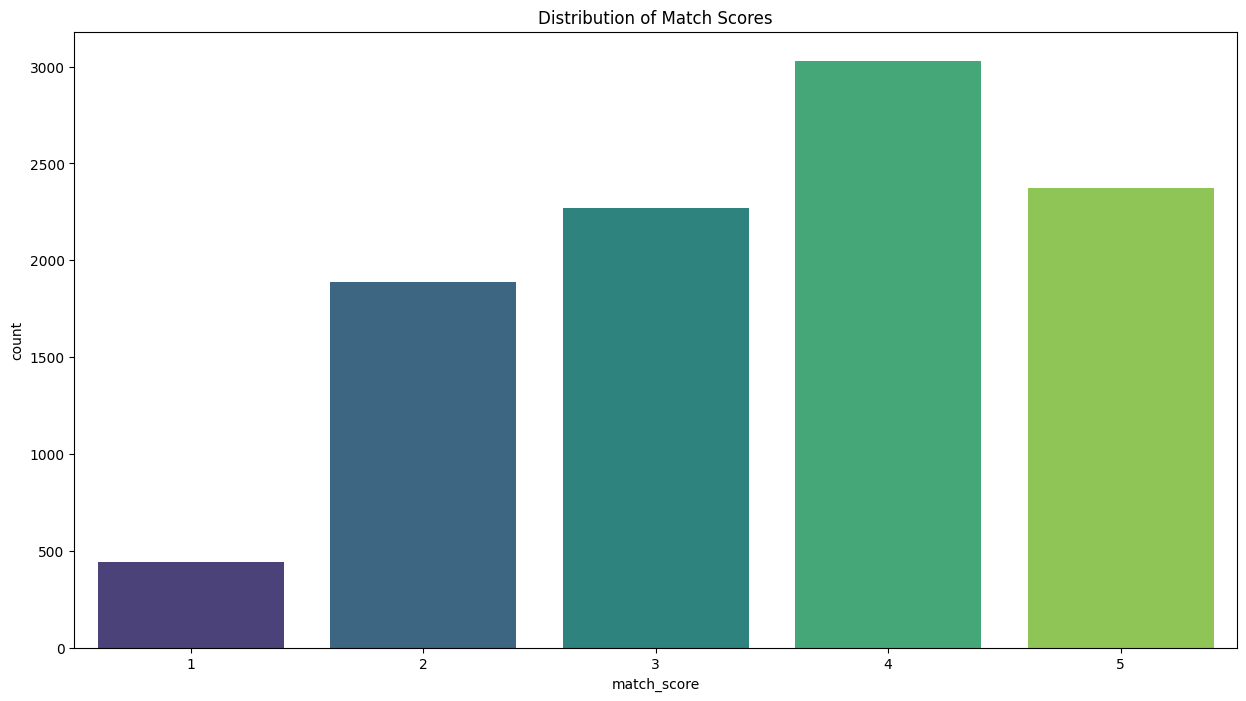

In [15]:
print(df['match_score'].value_counts().sort_index())
plt.figure(figsize=(15,8))
sns.countplot(x='match_score', data=df, palette='viridis')
plt.title('Distribution of Match Scores'); 
plt.show()

## 🧹 3. Text Cleaning & Feature Preparation  
**Purpose:**  
Normalize raw job descriptions and resumes into a uniform, token-ready format so downstream models can focus on semantic content rather than noise (case, punctuation, stop-words).

In [16]:
def clean(text:str)->str:
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)          # keep only letters
    text = " ".join(w for w in text.split() if w not in STOP)
    return text

df['clean_jd']  = df['job_description'].apply(clean)
df['clean_res'] = df['resume'].apply(clean)
df['text_pair'] = df['clean_jd'] + ' ' + df['clean_res']


## 🚀 4. Baseline Regression Pipeline  
**Purpose:**  
Build a quick, reproducible baseline that converts the cleaned text into TF-IDF vectors and then predicts the match score with Ridge regression. These metrics (MAE & R²) serve as the benchmark for any future improvements.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text_pair'], df['match_score'], test_size=.2, random_state=42)

vec  = TfidfVectorizer(max_features=20_000, ngram_range=(1,2))
Xtr  = vec.fit_transform(X_train)
Xte  = vec.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(Xtr, y_train)
pred  = model.predict(Xte)

print('MAE:', mean_absolute_error(y_test, pred))
print('R² :', r2_score(y_test, pred))

MAE: 0.7750173109849126
R² : 0.33221171901391966


## 📈 5. Residual Plot – Model Diagnostics  
**Purpose:**  
Visualize prediction errors to detect **heteroscedasticity**, **non-linearity**, or **outliers**. A healthy model shows residuals scattered evenly around zero with no obvious pattern.

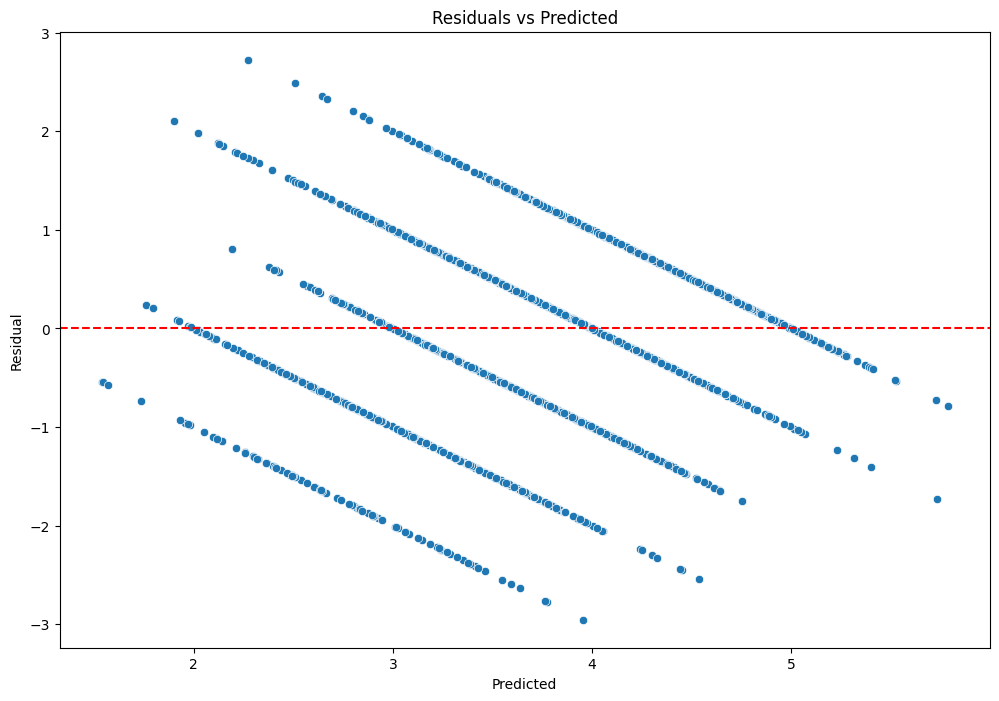

In [18]:
residuals = y_test - pred
plt.figure(figsize=(12,8))
sns.scatterplot(x=pred, y=residuals)
plt.axhline(0, ls='--', c='red')
plt.xlabel('Predicted'); plt.ylabel('Residual')
plt.title('Residuals vs Predicted'); plt.show()

## 🎯 6. Radar / Spider Chart – Skill Presence by Match Tier  
**Purpose:**  
Compare **frequency of key skills** between job descriptions that yield **low match scores (≤ 2)** versus **high scores (≥ 4)**. This highlights which technologies are **over-represented** in successful job–resume pairs.

In [27]:
low = df[df['match_score']<=2]['clean_jd']
high = df[df['match_score']>=4]['clean_jd']

skill_list = ['sql','python','tableau','power bi','machine learning','deep learning',
              'nlp','pandas','statistics','docker','git','java','spring','agile','keras','tensorflow']

def skill_freq(series, skills):
    return [series.str.contains(s, regex=False).sum() for s in skills]

low_counts  = skill_freq(low,  skill_list)
high_counts = skill_freq(high, skill_list)

fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=low_counts,  theta=skill_list, name='Low match (≤2)', line_color='crimson'))
fig.add_trace(go.Scatterpolar(r=high_counts, theta=skill_list, name='High match (≥4)', line_color='forestgreen'))
fig.update_layout(polar=dict(radialaxis=dict(visible=True)), title='Skill Presence Radar')
fig.show()

## 🔍 7. Top TF-IDF Tokens Driving Match Score  
**Purpose:**  
Surface the **individual n-grams** with the **largest positive and negative coefficients** from the Ridge regression model. These tokens are the strongest linear predictors of whether a resume–JD pair scores high or low.

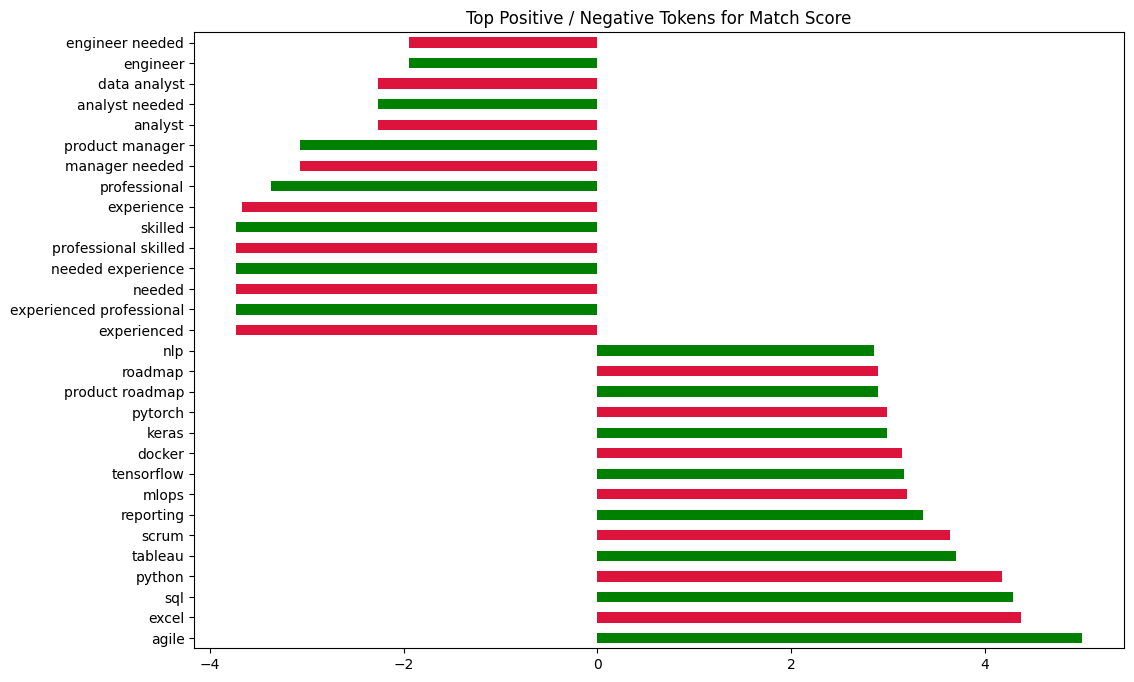

In [20]:
coef = pd.Series(model.coef_, index=vec.get_feature_names_out())
top_pos = coef.nlargest(15)
top_neg = coef.nsmallest(15)

plt.figure(figsize=(12,8))
pd.concat([top_pos, top_neg]).plot(kind='barh', color=['green','crimson'])
plt.title('Top Positive / Negative Tokens for Match Score'); 
plt.show()

## ☁️ 8. Word Cloud – Skills That Dominate HIGH-Scoring Pairs  
**Purpose:**  
Create an **intuitive visual summary** of the most frequent tokens appearing in **job descriptions that achieve match scores ≥ 4**. Larger words imply higher prevalence, instantly highlighting the **skill vocabulary** tied to successful matches.

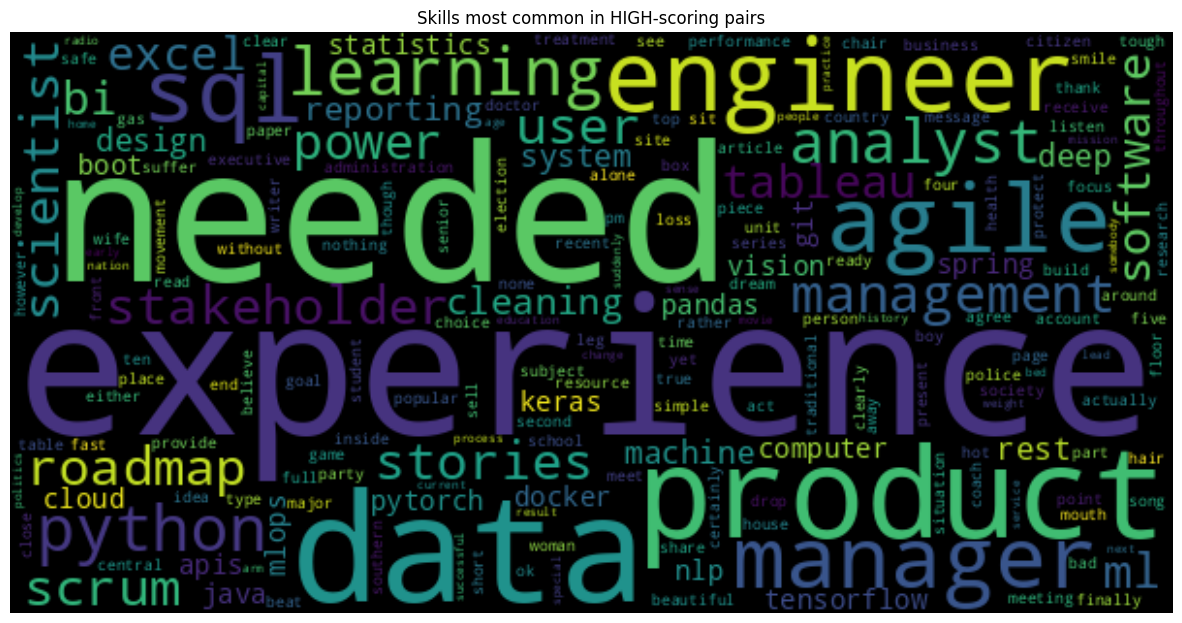

In [21]:
high = df[df['match_score']>=4]
all_words = ' '.join(high['clean_jd']).split()
freq = pd.Series(all_words).value_counts()

from wordcloud import WordCloud
wc = WordCloud(width=600, height=300, background_color='black').generate_from_frequencies(freq)
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear'); plt.axis('off')
plt.title('Skills most common in HIGH-scoring pairs');
plt.show()

## 📊 9. True vs Predicted Match Score  
**Purpose:**  
Visually assess how well the Ridge regression model aligns predicted scores with actual scores. A tight diagonal cluster indicates strong predictive performance.

/tmp/ipykernel_124439/2009993067.py:2: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



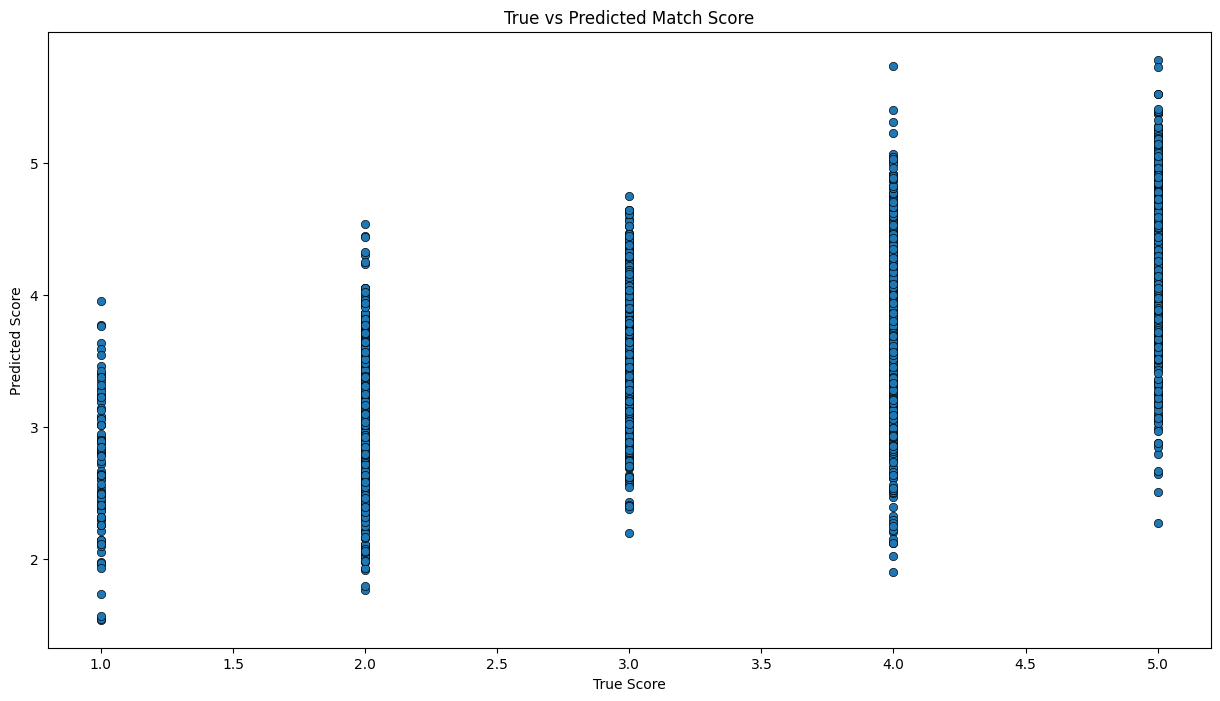

In [22]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=y_test, y=pred ,palette='viridis', edgecolor='black')
plt.xlabel('True Score'); 
plt.ylabel('Predicted Score')
plt.title('True vs Predicted Match Score');
plt.show()

## 🔁 10. Word-Shift Graph – Tokens Over-Represented in HIGH-Score JDs  
**Purpose:**  
Identify which **individual tokens** appear **significantly more often** in **high-scoring job descriptions** (≥ 4) compared to low-scoring ones (≤ 2). This highlights the **lexical gaps** between successful and unsuccessful matches.

/tmp/ipykernel_124439/884112088.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




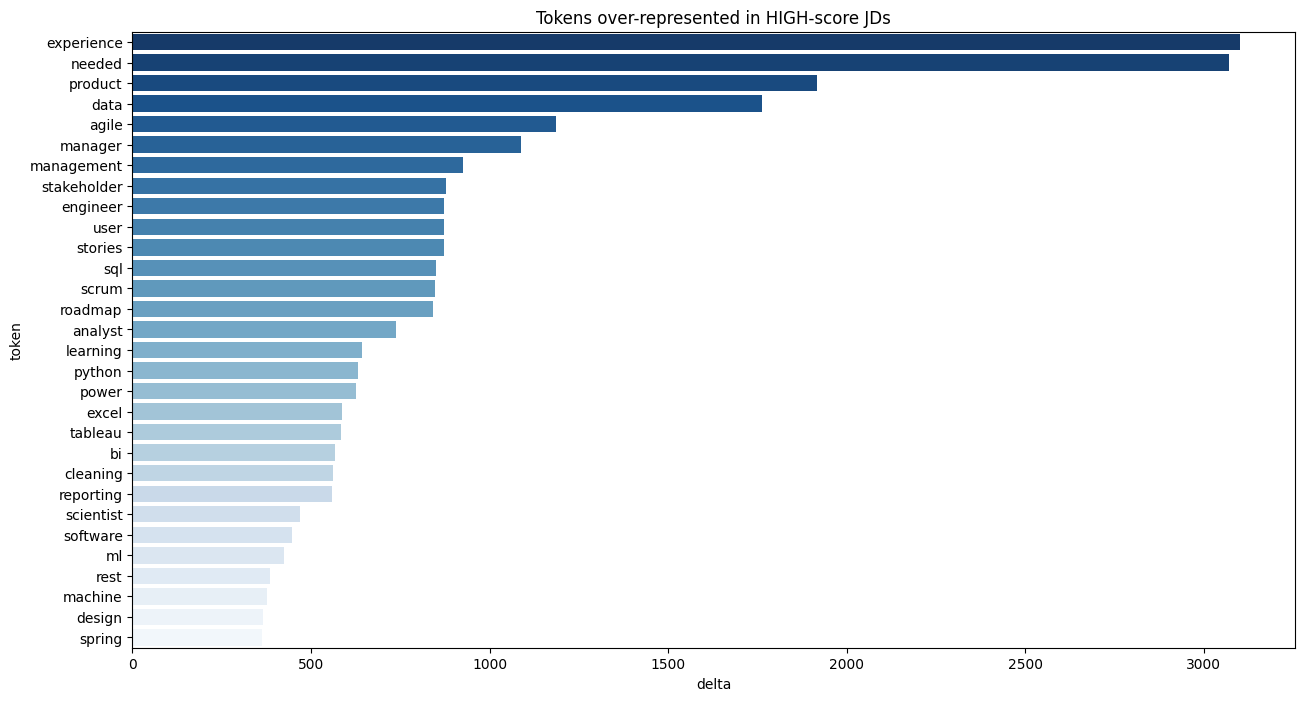

In [26]:
low_tokens  = Counter(' '.join(low).split())
high_tokens = Counter(' '.join(high).split())
shift = (high_tokens - low_tokens).most_common(30)
shift_df = pd.DataFrame(shift, columns=['token','delta'])
fig = plt.figure(figsize=(15,8))
sns.barplot(x='delta', y='token', data=shift_df, palette='Blues_r')
plt.title('Tokens over-represented in HIGH-score JDs'); 
plt.show()